# Diffusion Finetuning For Image Generation

Import Libraries

In [13]:
!pip install torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 876.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## Loading MNIST Dataset

In [15]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 38.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.23MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.46MB/s]


Check the images in the dataset

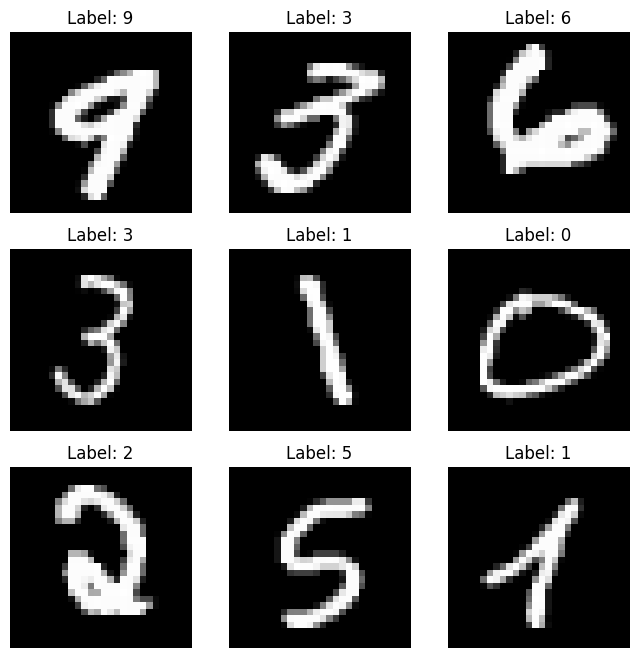

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images
def display_images(images, labels):
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(f"Label: {labels[i]}")
        ax.axis('off')
    plt.show()

# Get a batch of images and labels
for images, labels in train_loader:
    # Display the first 9 images
    display_images(images[:9], labels[:9])
    break # Exit after displaying one batch


## Define a Simple Denoising Model (U-Net style)

In [28]:
class SimpleDenoise(nn.Module):

  def __init__(self):
    super(SimpleDenoise, self).__init__()
    self.net = nn.Sequential(
        nn.Conv2d(2,32, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 32, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 1, 3, padding=1),
    )
  def forward(self, x, t):
    # t is noise level, here just concatenate it as an extra channel
    t = t.view(-1, 1, 1, 1).expand(-1, 1, x.shape[2], x.shape[3]) # Expand t to match x's spatial dimensions
    x = torch.cat([x, t], dim=1)
    return self.net(x)

## Fine-tuning Step

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SimpleDenoise().to(device)
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
loss_fn = nn.MSELoss()

## Training Loop

In [43]:
for epoch in range(10):  # Very small number of epochs for demo
    for images, _ in train_loader:
        images = images.to(device)

        noise = torch.randn_like(images)
        t = torch.rand((images.size(0), 1)).to(device)

        noised_images = (1 - t.view(-1, 1, 1, 1)) * images + t.view(-1, 1, 1, 1) * noise
        pred = model(noised_images, t.view(-1, 1))

        loss = loss_fn(pred, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} Loss: {loss.item():.4f}")


Epoch 1 Loss: 0.0346
Epoch 2 Loss: 0.0562
Epoch 3 Loss: 0.0314
Epoch 4 Loss: 0.0489
Epoch 5 Loss: 0.0344
Epoch 6 Loss: 0.0399
Epoch 7 Loss: 0.0435
Epoch 8 Loss: 0.0338
Epoch 9 Loss: 0.0257
Epoch 10 Loss: 0.0395


## Generating new Images

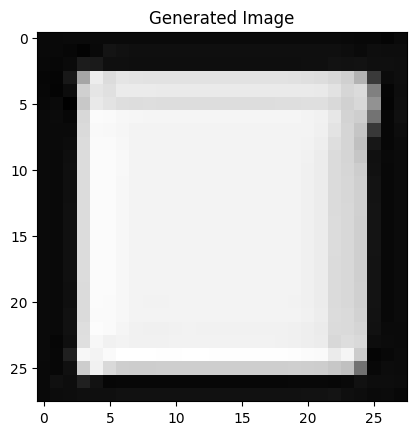

In [45]:
# Start from noise
x = torch.randn(1, 1, 28, 28).to(device)
steps = 100  # number of denoising steps

model.eval()
with torch.no_grad():
    for i in reversed(range(steps)):
        t = torch.full((1, 1), i / steps).to(device)
        x = model(x, t.view(-1, 1, 1, 1))

# Visualize generated image
x = x.squeeze().cpu().numpy()
plt.imshow(x, cmap='gray')
plt.title('Generated Image')
plt.show()


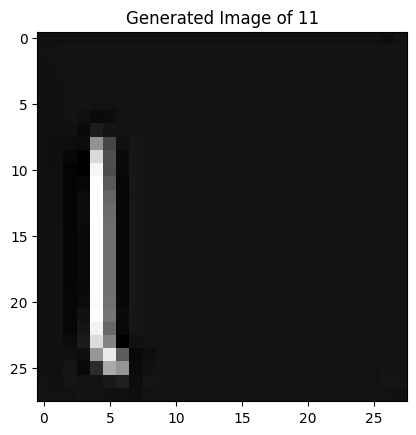

In [53]:
# prompt: ask the model to generate an image of 11

# Start from noise
x = torch.randn(1, 1, 28, 28).to(device)
steps = 5000  # number of denoising steps
target_number = 11 # Define the target number

model.eval()
with torch.no_grad():
    for i in reversed(range(steps)):
        t = torch.full((1, 1), i / steps).to(device)
        x = model(x, t.view(-1, 1, 1, 1))

# Visualize generated image
x = x.squeeze().cpu().numpy()
plt.imshow(x, cmap='gray')
plt.title(f'Generated Image of {target_number}') # Set title to reflect target number
plt.show()


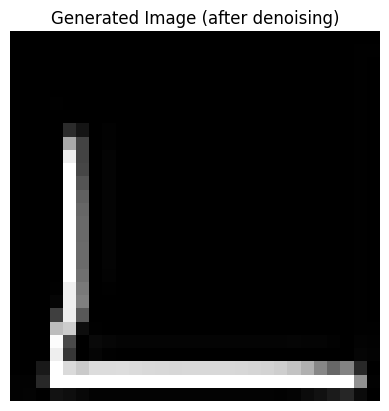

In [52]:
x = torch.randn(1, 1, 28, 28).to(device)
steps = 5000

model.eval()
with torch.no_grad():
    for i in reversed(range(steps)):
        t = torch.full((1, 1), i / steps).to(device)
        x = model(x, t)
        if i > 0:
            noise = torch.randn_like(x) * (i / steps)
            x += noise

x = x.squeeze().cpu().clamp(0, 1).numpy()
plt.imshow(x, cmap='gray')
plt.title('Generated Image (after denoising)')
plt.axis('off')
plt.show()